# Multi Mode Interferrometer

> Optimizing an MMI for low loss

In [ ]:
#| default_exp mmi


The question states:
> MMI2x2, design a 400nm thick Silicon Nitride 2x2 coupler for low loss at 1550 for TE polarization

Let's use black box optimization to find the width and length

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| hide
from skill_challenge.util import np, gf, gt, plt, nm

In [ ]:
import re
import json
import shutil
import subprocess
import importlib
import tempfile
from pathlib import Path
from functools import partial

import numpy as np
import pandas as pd
import ray
import ray.air
import ray.air.session
from ray import tune

import gdsfactory as gf
from gdsfactory.config import PATH
from gdsfactory.generic_tech import get_generic_pdk

gf.config.rich_output()
PDK = get_generic_pdk()
PDK.activate()

tmp = PATH.optimiser
tmp.mkdir(exist_ok=True)

## Component to be optimized

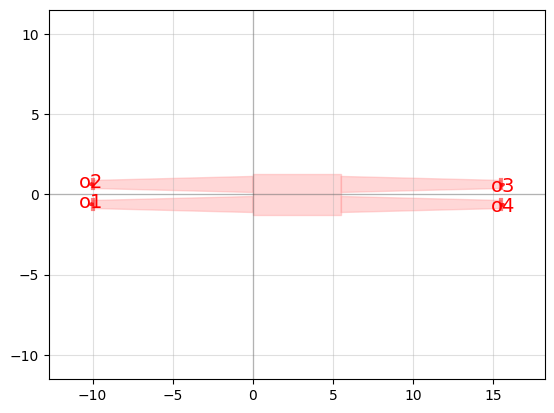

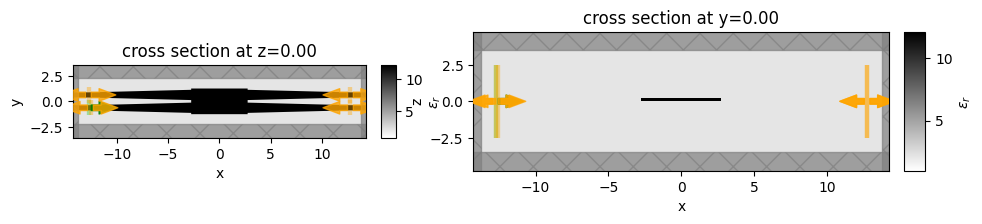

In [ ]:
c = gf.components.mmi2x2()
c.plot(show_ports=True)
s = gt.get_simulation(c, port_source_name="o1")
fig = gt.plot_simulation(s)

### Intermezzo: tidy3d and `write_sparameters`
in the 2x2 mmi we have a lot of symmetry so it would make sense to use it for our S-parameter simulation (we actually only need one simulation). Unfortunately the functionality provided by gdsfactory to achieve that was [broken](https://github.com/gdsfactory/gdsfactory/issues/1681) and I had to [fix it](https://github.com/gdsfactory/gdsfactory/pull/1683). 


In [ ]:
symmetry = {
  "o1": {
    "s11": ["s22","s33","s44"], "s21": ["s12","s34","s43"], "s31": ["s13","s24","s42"], "s41": ["s14","s23","s32"],
  }
}

df = gt.write_sparameters(c, port_symmetries=symmetry, is_3d=False, verbose=True)

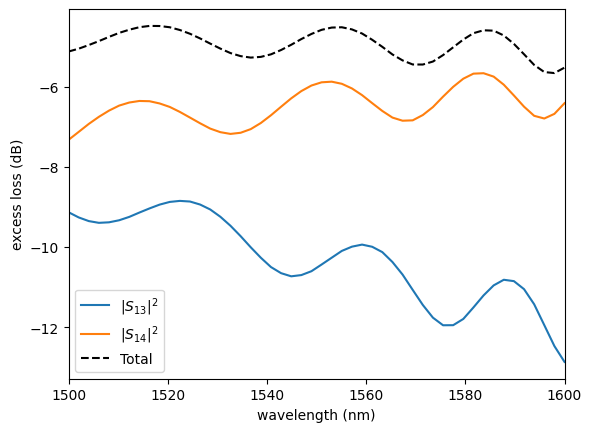

In [ ]:
import gdsfactory.simulation as sim
sim.plot.plot_loss2x2(df)

In [ ]:
def loss_S21_L1(x, target):
    r"""Loss function. Returns :math:`$\sum_i L_1(x_i)$` and :math:`$x$` as a tuple"""
    return np.abs(target - x), x

In [ ]:
loss = partial(loss_S21_L1, target=0.5)

In [ ]:
search_config = {
    "length_mmi": tune.uniform(0.05, 2),
    "width_mmi": tune.uniform(0.05, 2),
}

# pylint: disable=wrong-import-position,ungrouped-imports
from ray.tune.search.hyperopt import HyperOptSearch

tune_config = tune.TuneConfig(
    metric="loss",
    mode="min",
    search_alg=HyperOptSearch(),
    max_concurrent_trials=10,  # simulations to run in parallel
    num_samples=-1,  # max iterations, can be -1 for infinite
    time_budget_s=60
    * 20,  # time after which optimisation is stopped. May be useful along with ``num_samples=-1``.
)

In [ ]:
from ray.air import session
from ray.air.checkpoint import Checkpoint
def trainable_simulations(config):
    """Training step, or `trainable`, function for Ray Tune to run simulations and return results."""

    # Component to optimise

    # Simulate and get output
    dirpath = tmp / (ray.air.session.get_trial_id() or "debug")

    c = gf.components.mmi2x2(**config)
    s_params = gt.write_sparameters(c, dirpath=dirpath, port_symmetries=symmetry, is_3d=False)

    s_params_abs = np.concatenate((
        np.abs(s_params["o3@0,o1@0"]) ** 2,
        np.abs(s_params["o4@0,o1@0"]) ** 2,
    ))

    loss_x, x = loss(s_params_abs)
    if not np.isscalar(x):  # for many wavelengths, consider sum and mean
        loss_x, x = loss_x.sum(), x.mean()

    metrics = {"loss": loss_x, "value": x}
    checkpoint = Checkpoint.from_dict({"epoch": 1})
    session.report(metrics, checkpoint=checkpoint)

    return metrics

Testing whether everything works as planned

In [ ]:
# trainable_simulations(dict(length_mmi=1.8, width_mmi=1))

Let's run the optimization

In [ ]:
#| eval: false
tuner = tune.Tuner(
    tune.with_resources(
        trainable_simulations, {"cpu": 1}
    ),  # maximum resources given to a worker, it also supports 'gpu'
    param_space=search_config,
    tune_config=tune_config,
    run_config=ray.air.RunConfig(
        local_dir=tmp / "ray_results2",
        log_to_file=True,
        verbose=2,  # Intermediate results in Jupyter
    ),
)

# Previous simulations can be restored with, see https://docs.ray.io/en/latest/tune/tutorials/tune-stopping.html
# tuner = Tuner.restore(path=tmp / "ray_results/my_experiment")


results = tuner.fit()
df = results.get_dataframe()
df

2023-05-21 20:16:51,229	WARNING services.py:1816 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67108864 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=2.45gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2023-05-21 20:16:52,349	INFO worker.py:1616 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
2023-05-21 20:16:57,345	INFO tune.py:218 -- Initializing Ray automatically. For cluster usage or custom Ray initialization, call `ray.init(...)` before `Tuner(...)`.
2023-05-21 20:16:57.362 | WARNING  | gdsfactory.config:showwarning:62 - The `local_dir` argument of `Experiment is deprecated. Use `storage_path` or set the `TUNE_RESULT_DIR` environment variable instead.
/usr/local/lib/python3.1

Tune Status 
 
 
 Current time: 2023-05-21 20:18:45 
 Running for: 00:01:48.41 
 Memory: 5.2/9.7 GiB 
 
 
 
 
 
 System Info 
 Using FIFO scheduling algorithm. Logical resource usage: 0.4/4 CPUs, 0/0 GPUs
 
 
 
 
 
 Trial Status 
 
 
 Trial name status loc length_mmi width_mmi 
 
 
 trainable_simulations_05675c0c RUNNING 172.17.0.2:14491 0.410018 0.810596 
 trainable_simulations_6969d3f3 RUNNING 172.17.0.2:14706 0.53538 1.81078 
 trainable_simulations_0524299d RUNNING 172.17.0.2:14938 0.145312 0.542223 
 trainable_simulations_b4fe10ed RUNNING 172.17.0.2:15109 1.06536 1.19479

(trainable_simulations pid=14491) 2023-05-21 20:17:30.712 | WARNING  | gdsfactory.pdk:get_active_pdk:563 - No active PDK. Activating generic PDK.
(trainable_simulations pid=14491) 


(trainable_simulations pid=14491) [20:17:31] WARNING: Structure at structures[1] has bounds that extend  log.py:50
(trainable_simulations pid=14491)            exactly to simulation edges. This can cause unexpected               
(trainable_simulations pid=14491)            behavior. If intending to extend the structure to infinity           
(trainable_simulations pid=14491)            along one dimension, use td.inf as a size variable instead           
(trainable_simulations pid=14491)            to make this explicit. Skipping check for structure indexes          
(trainable_simulations pid=14491)            > 1.                                                                 
(trainable_simulations pid=14491)            WARNING: If the simulation is intended to be 2D in the      log.py:50
(trainable_simulations pid=14491)            plane normal to the z axis, using a PML or absorbing                 
(trainable_simulations pid=14491)            boundary along that axis is incorre

(trainable_simulations pid=14706) 
(trainable_simulations pid=14706) 


(trainable_simulations pid=14706)            'Periodic' boundary along z.                                         
(trainable_simulations pid=14706)            'Periodic' boundary along z.                                         
(trainable_simulations pid=14706)            'Periodic' boundary along z.                                         
(trainable_simulations pid=14706)            'Periodic' boundary along z.                                         
(trainable_simulations pid=14706)            'Periodic' boundary along z.                                         
(trainable_simulations pid=14706)            'Periodic' boundary along z.                                         
(trainable_simulations pid=14706)            'Periodic' boundary along z.                                         
(trainable_simulations pid=14706)            'Periodic' boundary along z.                                         
(trainable_simulations pid=14706)            'Periodic' boundary along z.       

(trainable_simulations pid=14938) 2023-05-21 20:18:18.451 | WARNING  | gdsfactory.pdk:get_active_pdk:563 - No active PDK. Activating generic PDK.
(trainable_simulations pid=14938) 


(trainable_simulations pid=14938) [20:18:19] WARNING: Structure at structures[1] has bounds that extend  log.py:50
(trainable_simulations pid=14938)            exactly to simulation edges. This can cause unexpected               
(trainable_simulations pid=14938)            behavior. If intending to extend the structure to infinity           
(trainable_simulations pid=14938)            along one dimension, use td.inf as a size variable instead           
(trainable_simulations pid=14938)            to make this explicit. Skipping check for structure indexes          
(trainable_simulations pid=14938)            > 1.                                                                 
(trainable_simulations pid=14938)            WARNING: If the simulation is intended to be 2D in the      log.py:50
(trainable_simulations pid=14938)            plane normal to the z axis, using a PML or absorbing                 
(trainable_simulations pid=14938)            boundary along that axis is incorre

(trainable_simulations pid=14491) [20:18:46] WARNING: Structure at structures[1] has bounds that extend  log.py:50
(trainable_simulations pid=14491)            exactly to simulation edges. This can cause unexpected               
(trainable_simulations pid=14491)            behavior. If intending to extend the structure to infinity           
(trainable_simulations pid=14491)            along one dimension, use td.inf as a size variable instead           
(trainable_simulations pid=14491)            to make this explicit. Skipping check for structure indexes          
(trainable_simulations pid=14491)            > 1.                                                                 
(trainable_simulations pid=14491)            WARNING: If the simulation is intended to be 2D in the      log.py:50
(trainable_simulations pid=14491)            plane normal to the z axis, using a PML or absorbing                 
(trainable_simulations pid=14491)            boundary along that axis is incorre

(trainable_simulations pid=15488) 2023-05-21 20:19:45.471 | WARNING  | gdsfactory.pdk:get_active_pdk:563 - No active PDK. Activating generic PDK.
(trainable_simulations pid=15488) 


(trainable_simulations pid=15488) [20:19:47] WARNING: Structure at structures[1] has bounds that extend  log.py:50
(trainable_simulations pid=15488)            exactly to simulation edges. This can cause unexpected               
(trainable_simulations pid=15488)            behavior. If intending to extend the structure to infinity           
(trainable_simulations pid=15488)            along one dimension, use td.inf as a size variable instead           
(trainable_simulations pid=15488)            to make this explicit. Skipping check for structure indexes          
(trainable_simulations pid=15488)            > 1.                                                                 
(trainable_simulations pid=15488)            WARNING: If the simulation is intended to be 2D in the      log.py:50
(trainable_simulations pid=15488)            plane normal to the z axis, using a PML or absorbing                 
(trainable_simulations pid=15488)            boundary along that axis is incorre

2023-05-21 20:21:11,020	ERROR trial_runner.py:1450 -- Trial trainable_simulations_d4d4756c: Error happened when processing _ExecutorEventType.TRAINING_RESULT.
ray.exceptions.RayTaskError(BlockingIOError): ray::ImplicitFunc.train() (pid=15109, ip=172.17.0.2, repr=trainable_simulations)
  File "/usr/local/lib/python3.10/site-packages/ray/tune/trainable/trainable.py", line 384, in train
    raise skipped from exception_cause(skipped)
  File "/usr/local/lib/python3.10/site-packages/ray/tune/trainable/function_trainable.py", line 336, in entrypoint
    return self._trainable_func(
  File "/usr/local/lib/python3.10/site-packages/ray/tune/trainable/function_trainable.py", line 653, in _trainable_func
    output = fn()
  File "/tmp/ipykernel_13945/2853010775.py", line 12, in trainable_simulations
  File "/usr/local/lib/python3.10/site-packages/gdsfactory/simulation/gtidy3d/write_sparameters.py", line 196, in write_sparameters
    batch_data = get_results_batch(sims, verbose=verbose)
  File "/u

2023-05-21 20:21:19,027	WARNING worker.py:1986 -- WARNING: 16 PYTHON worker processes have been started on node: 1d1b975c5f69712cddd0db63303e59a2938ef2eb8f8750b67d81f003 with address: 172.17.0.2. This could be a result of using a large number of actors, or due to tasks blocked in ray.get() calls (see https://github.com/ray-project/ray/issues/3644 for some discussion of workarounds).


(trainable_simulations pid=15493)            > 1.                                                                 
(trainable_simulations pid=15493)            > 1.                                                                 
(trainable_simulations pid=15493)            > 1.                                                                 
(trainable_simulations pid=15493)            > 1.                                                                 
(trainable_simulations pid=15487) [20:21:21] WARNING: Structure at structures[1] has bounds that extend  log.py:50 [repeated 2x across cluster]
(trainable_simulations pid=15487)            exactly to simulation edges. This can cause unexpected                [repeated 2x across cluster]
(trainable_simulations pid=15487)            behavior. If intending to extend the structure to infinity            [repeated 2x across cluster]
(trainable_simulations pid=15487)            along one dimension, use td.inf as a size variable instead     

2023-05-21 20:21:31,089	WARNING worker.py:1986 -- WARNING: 20 PYTHON worker processes have been started on node: 1d1b975c5f69712cddd0db63303e59a2938ef2eb8f8750b67d81f003 with address: 172.17.0.2. This could be a result of using a large number of actors, or due to tasks blocked in ray.get() calls (see https://github.com/ray-project/ray/issues/3644 for some discussion of workarounds).
2023-05-21 20:21:56,318	WARNING tune.py:184 -- Stop signal received (e.g. via SIGINT/Ctrl+C), ending Ray Tune run. This will try to checkpoint the experiment state one last time. Press CTRL+C (or send SIGINT/SIGKILL/SIGTERM) to skip. 


(trainable_simulations pid=14938) [20:22:11] WARNING: Structure at structures[1] has bounds that extend  log.py:50 [repeated 6x across cluster]
(trainable_simulations pid=14938)            exactly to simulation edges. This can cause unexpected                [repeated 6x across cluster]
(trainable_simulations pid=14938)            behavior. If intending to extend the structure to infinity            [repeated 6x across cluster]
(trainable_simulations pid=14938)            along one dimension, use td.inf as a size variable instead            [repeated 6x across cluster]
(trainable_simulations pid=14938)            to make this explicit. Skipping check for structure indexes           [repeated 6x across cluster]
(trainable_simulations pid=14938)            > 1.                                                                  [repeated 6x across cluster]
(trainable_simulations pid=14938)            WARNING: If the simulation is intended to be 2D in the      log.py:50 [repeated 6x across c

(trainable_simulations pid=15490) [20:22:28] WARNING: Structure at structures[1] has bounds that extend  log.py:50 [repeated 2x across cluster]
(trainable_simulations pid=15490)            exactly to simulation edges. This can cause unexpected                [repeated 2x across cluster]
(trainable_simulations pid=15490)            behavior. If intending to extend the structure to infinity            [repeated 2x across cluster]
(trainable_simulations pid=15490)            along one dimension, use td.inf as a size variable instead            [repeated 2x across cluster]
(trainable_simulations pid=15490)            to make this explicit. Skipping check for structure indexes           [repeated 2x across cluster]
(trainable_simulations pid=15490)            > 1.                                                                  [repeated 2x across cluster]
(trainable_simulations pid=17482)            > 1.                                                                 
(trainable_simulation

2023-05-21 20:23:24,817	ERROR tune.py:941 -- Trials did not complete: [trainable_simulations_d4d4756c, trainable_simulations_948ff22a, trainable_simulations_93e783d4, trainable_simulations_b322cb68, trainable_simulations_a7c3c09e, trainable_simulations_5e76deca, trainable_simulations_1f084ead, trainable_simulations_66564a46, trainable_simulations_e2cf3f07, trainable_simulations_56aba985, trainable_simulations_d977b518]
2023-05-21 20:23:24,828	INFO tune.py:945 -- Total run time: 387.47 seconds (316.70 seconds for the tuning loop).
2023-05-21 20:23:24,835	WARNING tune.py:954 -- Experiment has been interrupted, but the most recent state was saved.
Continue running this experiment with: Tuner.restore(path="/usr/local/lib/python3.10/site-packages/tune/ray_results2/trainable_simulations_2023-05-21_20-16-47", trainable=...)


/usr/local/lib/python3.10/site-packages/tune/ray_results2/trainable_simulations_2023-05-21_20-16-47

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()